In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
#from algorithms import *
from distrib_algs import *
from utils import *
from tests import *

%matplotlib inline

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42

NameError: name 'matplotlib' is not defined

In [2]:
data_size = 2000

# Create the problem (for each value of num_of_workers run this code once)

In [3]:
#%%time
dataset = "madelon"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Datasize: ", m, ", dimension: ", n)

Datasize:  2000 , dimension:  500


In [4]:
#%%time
num_of_workers = 20
A, y, m, n, sparsity_A, data_split = prepare_data_distrib(dataset, data_size, num_of_workers)
print("New datasize: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L_distrib(dataset, A)
denseA = A.toarray()
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

New datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0
Sparsity of A:  0.999999


In [5]:
#save_split(dataset, num_of_workers, data_split)

# Find the solution (run these cells only once!)

In [21]:
%%time
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

Datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0
CPU times: user 347 ms, sys: 16.5 ms, total: 364 ms
Wall time: 362 ms


In [22]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L/10000
l1 = 0

In [23]:
#%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-30)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

True
0.667919553429517
      fun: 0.667919553429517
 hess_inv: <500x500 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19513833e-06, -1.14802182e-06, -1.57086880e-06, -1.24663854e-06,
       -1.08680647e-06, -1.12584819e-06, -1.12978381e-06, -1.06953282e-06,
       -1.31745533e-06, -1.18540931e-06, -1.29612122e-06, -1.26147265e-06,
       -1.26096583e-06, -1.21364098e-06, -1.21998557e-06, -1.18801153e-06,
       -1.20946751e-06, -1.25138057e-06, -1.22716878e-06, -1.20091215e-06,
       -1.17682403e-06, -9.98060586e-07, -1.11525793e-06, -1.19050496e-06,
       -7.01537846e-07, -1.25833052e-06, -1.25999674e-06, -1.14995387e-06,
       -1.59201627e-06, -1.23770735e-06, -1.15967130e-06, -1.38310707e-06,
       -1.65027284e-06, -1.37797786e-06, -1.05127460e-06, -1.20979060e-06,
       -1.16423225e-06, -1.08907551e-06, -1.15197990e-06, -1.06486918e-06,
       -1.08813040e-06, -8.64791633e-07, -1.29367346e-06, -1.23449272e-06,
       -1.20149546e-06, -1.26943962e-06, -1.37852124

In [24]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Tests with 20 workers

In [4]:
#%%time
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

num_of_workers = 20
data_split = read_split(dataset, num_of_workers)
num_of_local_data = int(m/num_of_workers)
assert(num_of_local_data == len(data_split[0]))

Datasize:  2000 , dimension:  500
Smoothness constant of f         :  29790805.64933511
Average smoothness const of f_ij :  29904489.14662501
Worst smoothness const of f_ij   :  30596924.0


In [5]:
shift_param = 0.0001
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/10000
l1 = 0
batch_size = 1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = False
sparse_stoch = False

In [6]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  12.170929143981764
f(x^*) =  0.6679195537701466


In [8]:
1.0/(L+l2)

3.3564047302672275e-08

### Stochastic grad methods

In [50]:
%%time
S = 30
save_info_period = 1
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = ["top-1", 1]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 13.7 s, sys: 61.8 ms, total: 13.7 s
Wall time: 13.7 s


In [33]:
%%time
S = 120
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = identical
sparsificator_params = ["identical"]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 29.8 s, sys: 236 ms, total: 30 s
Wall time: 30 s


In [52]:
%%time
S = 30
save_info_period = 1
gamma = 1.0/(L+l2)
sparsificator = threshold
sparsificator_params = ["thr-13.27", 5e-4]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

CPU times: user 13 s, sys: 64.3 ms, total: 13.1 s
Wall time: 13.1 s


Initial func_vals is: 11.503009498638587
Initial func_vals is: 11.503009498638587


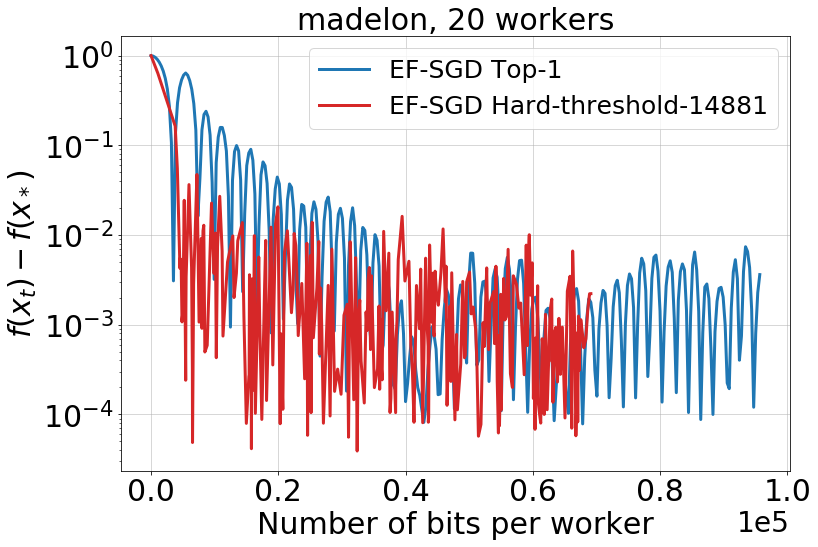

In [12]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "top-1"], 
           'EF-SGD Top-1', 300],
     ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "thr-13.27"], 
           'EF-SGD Hard-threshold-14881', 300],
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

In [ ]:
"sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"

Initial func_vals is: 11.503009498638587
Initial func_vals is: 11.503009498638587
Initial func_vals is: 11.503009498638587


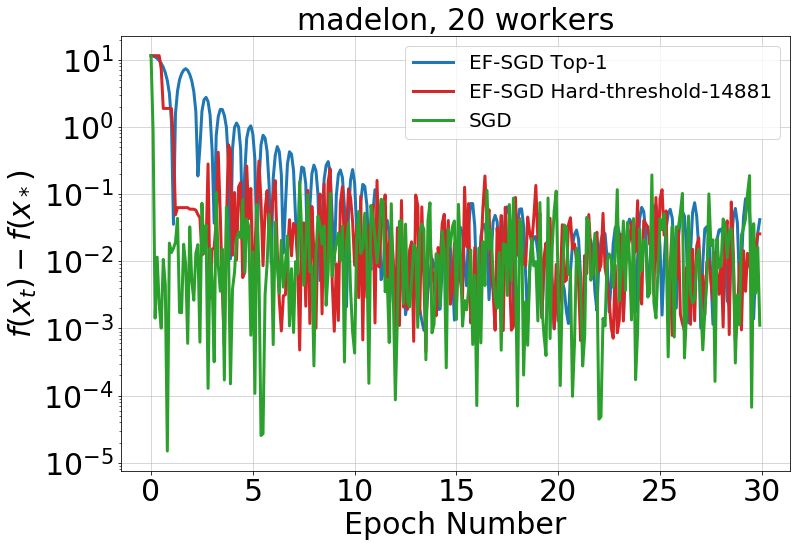

In [11]:
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "top-1"], 
           'EF-SGD Top-1', 300],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "thr-13.27"], 
           'EF-SGD Hard-threshold-14881', 300],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "identical"], 
           'SGD', 300],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 20
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+r" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"

save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Bits vs iterations

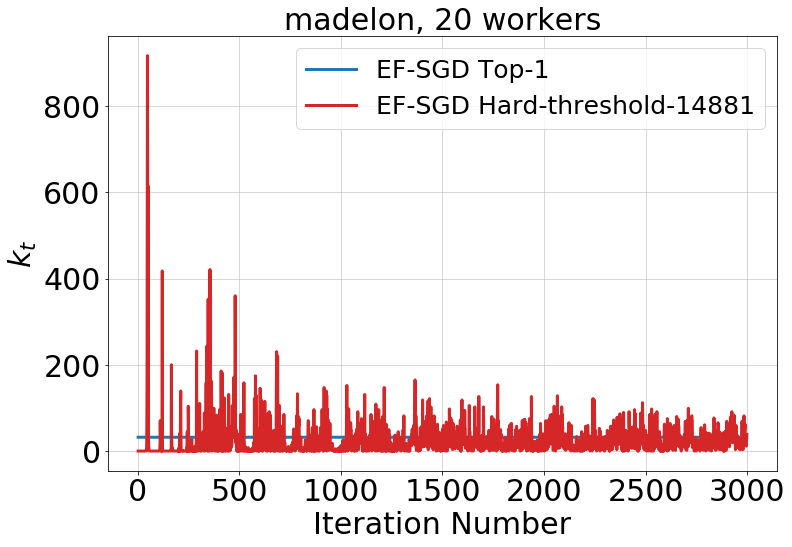

In [9]:
p = 1.0/num_of_local_data
methods = [
     ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 30, num_of_workers, "Top-1"], 
           'EF-SGD Top-1', 3000],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 30, num_of_workers, "thr-13.27"], 
           'EF-SGD Hard-threshold-14881', 3000],
]
mode_y = 'bits'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

# Error norm vs Iterations

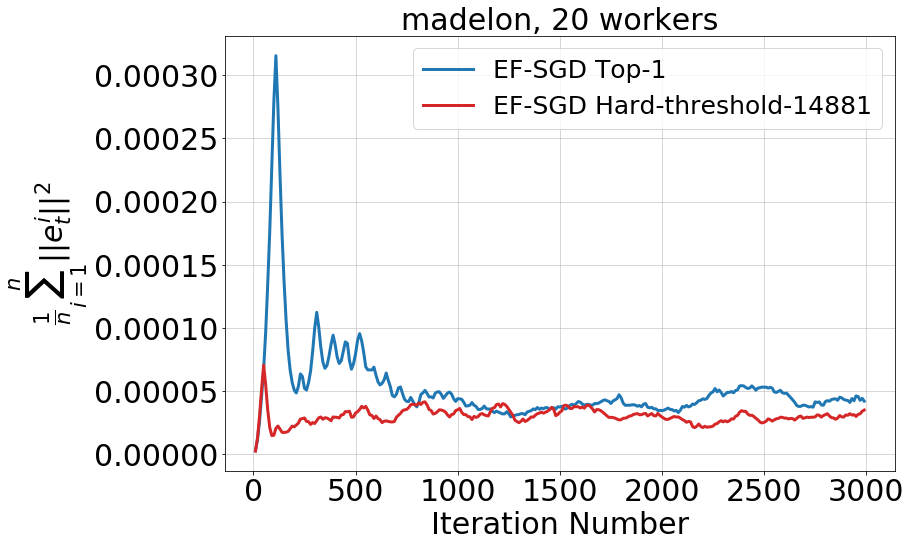

In [8]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "Top-1"], 
           'EF-SGD Top-1', 300],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 120, num_of_workers, "thr-13.27"], 
           'EF-SGD Hard-threshold-14881', 300],
]
mode_y = 'avg_error_norms'
mode_x = 'iters'
figsize = (12, 8)
title_size = 30
linewidth = 3
markersize = 0
legend_size = 25
xlabel_size = 30
ylabel_size = 30
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd_"+dataset+ "_num_of_workers_"+str(num_of_workers)+ "_" + mode_y +"_"+ mode_x + ".pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)